# Import Statements

In [1]:
import numpy
import torch
import torchvision
import pickle
from matplotlib import pyplot
import random
from torch import nn

# Load the model
Load the model that is to be attacked. I have used ```%load model.py``` to load the model.

In [2]:
# %load model.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class Propagator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(784,512)
        self.bn1 = nn.BatchNorm1d(512)
        self.layer2 = nn.Linear(512,512)
        self.layer3 = nn.Linear(512,256)
        self.layer4 = nn.Linear(256,64)
        self.bn2 = nn.BatchNorm1d(64)
        self.layer5 = nn.Linear(64,64)
        self.final_layer = nn.Linear(64,10)
    def forward(self,x):
        x = F.relu(self.bn1(self.layer1(x)))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.bn2(self.layer4(x)))
        x = F.relu(self.layer5(x))
        x = self.final_layer(x)
        x = F.log_softmax(x,dim=1)
        return x


In [4]:
model=(torch.load('trained_model.pt'))
print(type(model))
print(model)

<class 'type'>
<class '__main__.Propagator'>


# Load the data
Load the data from the file 'MNIST_data.pkl'

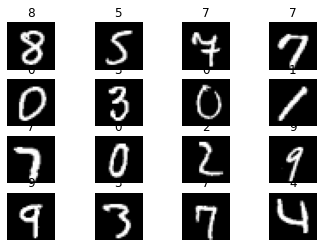

In [5]:
f=open('MNIST_data.pkl','rb')
data=pickle.load(f)
X=data['X']
y=data['y']
# print(X.shape,y.shape)
f.close()
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
for i in range(1,17):
    pyplot.subplot(4,4,i)
    idx = random.randrange(0,60000)
    image = X[idx].reshape(28,28)
    pyplot.imshow(image,cmap = 'gray')
    pyplot.title(y[idx][0])
    pyplot.axis('off')
pyplot.show()

In [6]:
class ImageDataSet(torch.utils.data.Dataset):
    def __init__(self,X,y):
        self.X = torch.from_numpy(X).float()
        self.y=torch.from_numpy(y)
    def __len__(self):
        return len(self.y)
    def __getitem__(self,idx):
        return self.X[idx]/256,self.y[idx]
dataset=ImageDataSet(X,y)
dataloader=torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=True)

# Attack
This contains the function to change the image

In [7]:
def fgsm_attack(image,epsilon,grad):
    perturbation=epsilon*(grad.sign())
    perturbed_image=image+perturbation
    peturbed_image=torch.clamp(perturbed_image,0,1)
    return perturbed_image

# Test
This function runs the model and returns the accuracy. It takes arguments as model, test_loader and epsilon value to be used.

In [8]:
def test(model,dataloader,epsilon):
    correct=0
    total=0
    for img,lbl in dataloader:
        total+=1
        out=model.forward(img)
        loss=nn.functional.nll_loss(out,lbl)
        loss.backward()
        grad=data.grad.data
        perturbed=fgsm_attack(img,epsilon,grad)
        pert_out=model.forward(perturbed)
        pred=pert_out.detach().numpy().max()
        if pred==lbl:
            correct+=1
    final_accuracy=correct/total*100
    return final_accuracy

In [54]:
test(model,dataloader,0)

TypeError: forward() missing 1 required positional argument: 'x'